In [1]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import networkx as nx
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mariagiustiniano/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Download the Dataset

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!mv /Users/mariagiustiniano/Downloads/kaggle.json  ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download aashita/nyt-comments

In [ ]:
!unzip 'nyt-comments' -d /Users/mariagiustiniano/com_1

In [ ]:
folder = '/Users/mariagiustiniano/com_1'
filelist = [[file.split('.')[0],os.path.join(folder,file)] for file in os.listdir('/Users/mariagiustiniano/com_1')]

[filelist.pop(i) for i in range(len(filelist)-2) if filelist[i][0][8:11] == 'May']

db = {}
db_a = {}

for file in filelist:
    if file[0].split('.')[0].startswith('C'):
        db[file[0].split('.')[0][8:]] = pd.read_csv(file[1], low_memory=False).loc[:,['commentID','commentBody','commentType','editorsSelection','recommendations','replyCount','parentID','inReplyTo','articleID','articleWordCount', 'printPage','sharing','sectionName','newDesk', 'compound']]
    else:
        db_a[file[0].split('.')[0][8:]] = pd.read_csv(file[1], low_memory=False)

keys= list(db.keys())

In [ ]:
sia= SentimentIntensityAnalyzer()
for key in keys:
    db[key]['editorsSelection']= db[key]['editorsSelection'].replace([True,False],[1,0])
    db[key]['replyCount']= db[key]['replyCount'].astype(float).apply(abs)
    db[key]['recommendations']= db[key]['recommendations'].astype(float).apply(abs)
    db[key]['compound']= db[key]['commentBody'].apply(lambda x: sia.polarity_scores(x)['compound'])

### Grouping replies

In [3]:
Score_comm={}
Pol_comm={}
def get_scores(df):
    for i in range(df.shape[0]):
        Score_comm[df.commentID.iloc[i]]=df.recommendations.iloc[i]
        Pol_comm[df.commentID.iloc[i]]= df['compound'].iloc[i]

In [4]:
for key in keys:
    get_scores(db[key])

In [5]:
def get_successors(df):
    nodes=[]
    for i in range(df.shape[0]):
        if df.parentID.iloc[i] !=0:
            nodes.append((df.parentID.iloc[i],df.commentID.iloc[i]))
    G=nx.DiGraph()
    G.add_edges_from(nodes)
    
    roots=[n for n,d in G.in_degree() if d==0]
    
    DAG=pd.DataFrame(roots, columns=['commentID'])
    
    successors=[]
    for comment in DAG.commentID:
        successors.append(list(nx.nodes(nx.dfs_tree(G,comment)))[1:])
    
    DAG['successorsID']=successors
    
    df = df.loc[df.parentID==0].merge(DAG, on='commentID', how= 'outer').fillna(0)
    return df

In [6]:
for key in keys:
    db[key] = get_successors(db[key])

In [7]:
def get_statistics(df):
    sd=[]
    sd_compound=[]
    succ_rec=[]
    for successor in df.successorsID:
        if successor == 0:
            succ_rec.append(0)
            sd.append(0)
            sd_compound.append(0)
            
        else:
            succ_rec.append(np.sum([Score_comm[comm] for comm in successor]))
            sd.append(np.std([Score_comm[comm] for comm in successor]))
            sd_compound.append(np.std([Pol_comm[comm] for comm in successor]))
            
    df['successors_recc']= succ_rec
    df['successors_sd']= sd
    df['pol_sd']= sd_compound
    df['score']=df[['recommendations','successors_recc']].sum(axis=1)
    return df

In [8]:
for key in keys:
    get_statistics(db[key])

### Comments analisys 

In [9]:
for key in keys:
    y,z=[],[]
    if key[-1]== '7':
        y.append(db[key])
        comments2017 = pd.concat(y, ignore_index=True)
    else:
        z.append(db[key])
        comments2018 = pd.concat(z ,ignore_index=True)

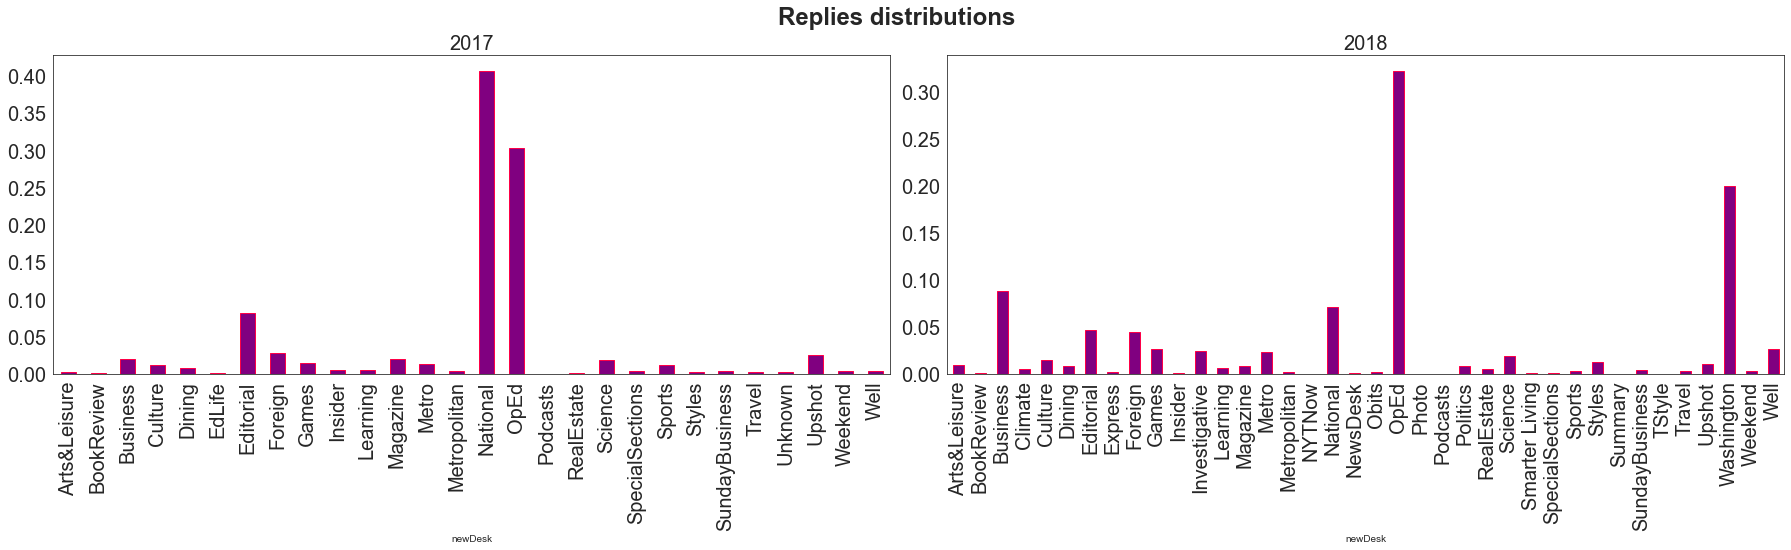

In [10]:
def bar_plot(df):
    a= df.groupby('newDesk')['replyCount'].sum()/df.loc[:,['replyCount']].sum(axis=0).values
    a.plot.bar(color='purple', edgecolor='#fd0047', fontsize=20)

sns.set_style('white')
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(25)

plt.subplot(1,2,1)
plt.gca().set_title('2017', fontsize= 20)
bar_plot(comments2017)

plt.subplot(1,2,2)
plt.gca().set_title('2018', fontsize=20)
bar_plot(comments2018)


fig.suptitle('Replies distributions', fontsize= 24, fontweight='bold')
fig.subplots_adjust(top=0.90)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.savefig('repDistr.pdf')

In [11]:
replies2017= pd.DataFrame({"avgRepCount":comments2017.groupby('newDesk')['replyCount'].mean()}).reset_index()
replies2017['sdRepCount']= replies2017.newDesk.map(comments2017.groupby('newDesk')['replyCount'].std())
replies2017['successors_sd']= replies2017.newDesk.map(comments2017.groupby('newDesk')['successors_sd'].mean())
replies2017['pol_sd']= replies2017.newDesk.map(comments2017.groupby('newDesk')['pol_sd'].mean())
replies2017= replies2017.sort_values(by='successors_sd',ascending=False).reset_index(drop=True)
replies2017.head(5)

,newDesk,avgRepCount,sdRepCount,successors_sd,pol_sd
0,National,0.797169,4.306404,0.170324,0.041981
1,Arts&Leisure,0.790191,2.663682,0.277978,0.050188
2,Editorial,0.593283,2.286357,0.181749,0.037334
3,Foreign,0.667211,2.267257,0.194492,0.045726
4,Games,1.271518,2.175320,0.217014,0.068332


In [13]:
replies2018= pd.DataFrame({"avgRepCount":comments2018.groupby('newDesk')['replyCount'].mean()}).reset_index()
replies2018['sdRepCount']= replies2018.newDesk.map(comments2018.groupby('newDesk')['replyCount'].std())
replies2018['successors_sd']= replies2018.newDesk.map(comments2018.groupby('newDesk')['successors_sd'].mean())
replies2018['pol_sd']= replies2018.newDesk.map(comments2018.groupby('newDesk')['pol_sd'].mean())
replies2018= replies2018.sort_values(by='successors_sd',ascending=False).reset_index(drop=True)
replies2018.head(5)

,newDesk,avgRepCount,sdRepCount,successors_sd,pol_sd
0,Investigative,0.785047,3.024914,0.238082,0.044788
1,OpEd,0.491420,2.978762,0.244950,0.031781
2,Editorial,0.576771,2.727962,0.242121,0.032939
3,Washington,0.531518,2.447239,0.169533,0.030945
4,Games,1.506527,2.368006,0.292668,0.082539


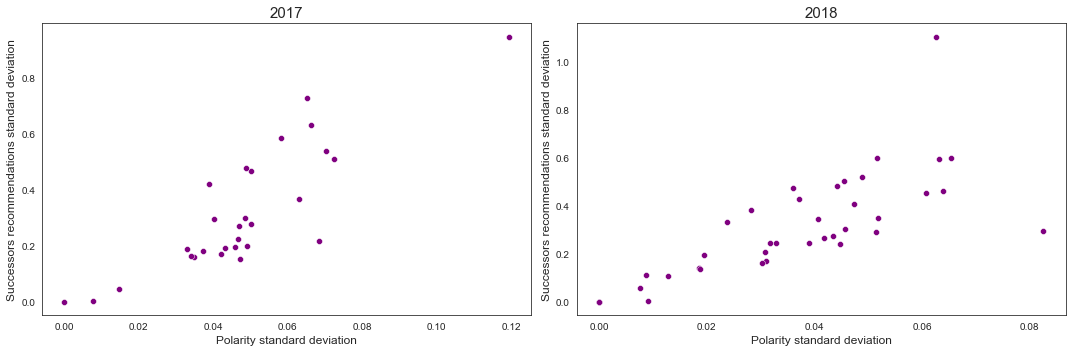

In [15]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)

plt.subplot(1,2,1)
a=sns.scatterplot(x = "pol_sd", y = "successors_sd", data = replies2017, color='purple')
a.set_xlabel("Polarity standard deviation", fontsize=12)
a.set_ylabel("Successors recommendations standard deviation", fontsize=12)
a.axes.set_title('2017',fontsize=15)

plt.subplot(1,2,2)
b=sns.scatterplot(x = "pol_sd", y = "successors_sd", data = replies2018, color='purple')
b.set_xlabel("Polarity standard deviation", fontsize=12)
b.set_ylabel("Successors recommendations standard deviation", fontsize=12)
b.axes.set_title("2018",fontsize=15)

plt.tight_layout()
#plt.savefig("pol_succSd_comments.pdf")

### Articles and topic analysis

In [10]:
for key in keys:
    db_a[key]['totRep']= db_a[key].articleID.map(db[key].groupby('articleID')['replyCount'].sum())
    db_a[key]['score_sd']=db_a[key].articleID.map(db[key].groupby('articleID')['score'].std().fillna(0))
    db_a[key]['polarity_sd']=db_a[key].articleID.map(db[key].groupby('articleID')['compound'].std().fillna(0))

In [11]:
def str_tolist(string):
    x = re.findall("'(.*?)'" ,string)
    return x

In [12]:
for key in keys:
    y,z=[],[]
    if key[-1]== '7':
        y.append(db_a[key])
        articles2017 = pd.concat(y, ignore_index=True)
        articles2017.keywords = articles2017.keywords.apply(lambda x: str_tolist(x))
        for i in range(articles2017.shape[0]):
            articles2017.keywords[i].append(articles2017.newDesk[i])
        articles2017= articles2017.loc[:,['articleID','byline','keywords','printPage','articleWordCount','totRep','score_sd','polarity_sd']]
        
    else:
        z.append(db_a[key])
        articles2018 = pd.concat(z ,ignore_index=True)
        articles2018.keywords = articles2018.keywords.apply(lambda x: str_tolist(x))
        for i in range(articles2018.shape[0]):
            articles2018.keywords[i].append(articles2018.newDesk[i])
        articles2018= articles2018.loc[:,['articleID','byline','keywords','printPage','articleWordCount','totRep','score_sd','polarity_sd']]

In [13]:
import pymongo
from pymongo import MongoClient

def unwind_list(df):
    client = MongoClient()
    db = client['db']
    collection = db[ "col" ]
    
    data= df.to_dict('records')
    collection.insert_many(data)
    
    pipeline = [
     {"$unwind": "$keywords"}
    ]
    
    new_df=pd.DataFrame(list(db.col.aggregate(pipeline))).drop('_id', axis=1)
    db.col.drop()
    return new_df

In [14]:
articles2017= unwind_list(articles2017)
articles2017= articles2017.loc[articles2017.keywords!=', ']
articles2018= unwind_list(articles2018)
articles2018= articles2018.loc[articles2018.keywords!=', ']

In [15]:
keywords2017= pd.DataFrame({'totsd':articles2017.groupby('keywords')['score_sd'].sum()}).reset_index()
keywords2017['totPol']=keywords2017.keywords.map(articles2017.groupby('keywords')['polarity_sd'].sum())
keywords2017['totRep']=keywords2017.keywords.map(articles2017.groupby('keywords')['totRep'].sum())
keywords2017['freq']=keywords2017.keywords.map(articles2017.keywords.value_counts(normalize=True))


keywords2018= pd.DataFrame({'totsd':articles2018.groupby('keywords')['score_sd'].sum()}).reset_index()
keywords2018['totPol']=keywords2018.keywords.map(articles2018.groupby('keywords')['polarity_sd'].sum())
keywords2018['totRep']=keywords2018.keywords.map(articles2018.groupby('keywords')['totRep'].sum())
keywords2018['freq']=keywords2018.keywords.map(articles2018.keywords.value_counts(normalize=True))

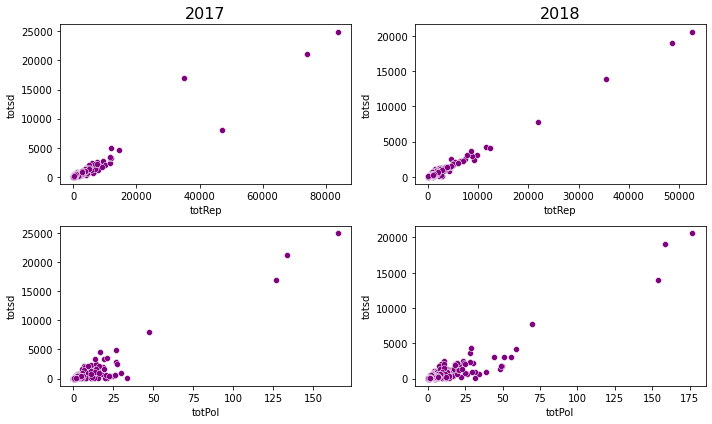

In [16]:
fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(10)
plt.subplot(2,2,1)
sns.scatterplot(x='totRep',y='totsd', data=keywords2017, color='purple');
plt.gca().set_title('2017', fontsize=16)
plt.subplot(2,2,2)
sns.scatterplot(x='totRep',y='totsd', data=keywords2018, color='purple');
plt.gca().set_title('2018', fontsize=16)
plt.subplot(2,2,3)
sns.scatterplot(x='totPol', y='totsd', data= keywords2017,color='purple');
plt.subplot(2,2,4)
sns.scatterplot(x='totPol', y='totsd', data= keywords2018,color='purple');
plt.tight_layout()
#plt.savefig('scatter_art.pdf')

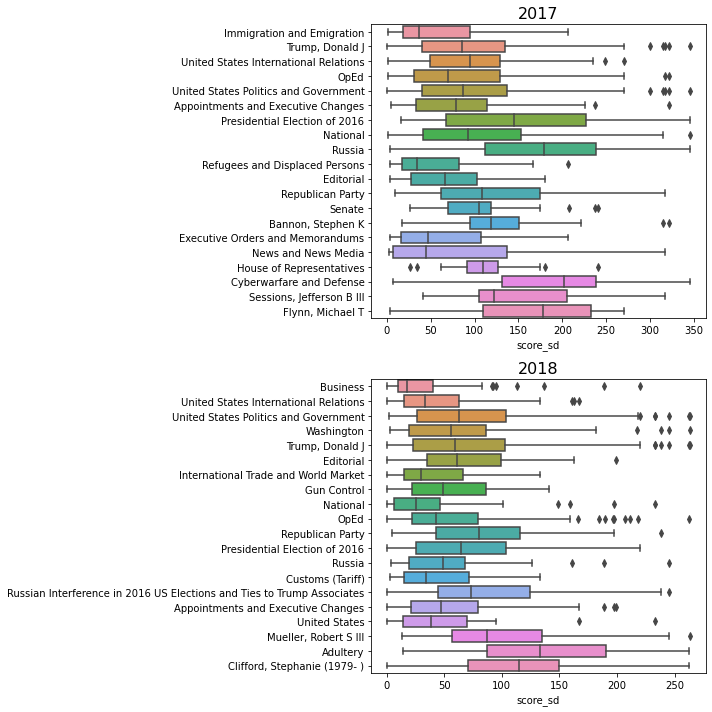

In [17]:
keys2017= keywords2017.sort_values(by='totsd',ascending=False).reset_index(drop = True)
keys2018= keywords2018.sort_values(by='totsd',ascending=False).reset_index(drop = True)

topic2017= [key for key in keys2017.keywords.head(20)]
topic2018= [key for key in keys2018.keywords.head(20)]
art2017= articles2017[articles2017.keywords.isin(topic2017)]
art2018= articles2018[articles2018.keywords.isin(topic2018)]


fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)

plt.subplot(2,1,1)
plt.gca().set_title('2017', fontsize=16)
ax=sns.boxplot(y='keywords',x='score_sd', data=art2017)
ax.set(ylabel=None);

plt.subplot(2,1,2)
plt.gca().set_title('2018', fontsize=16)
ax=sns.boxplot(y='keywords',x='score_sd', data=art2018)
ax.set(ylabel=None);
plt.tight_layout()
#plt.savefig('boxplot_score_sd.pdf')

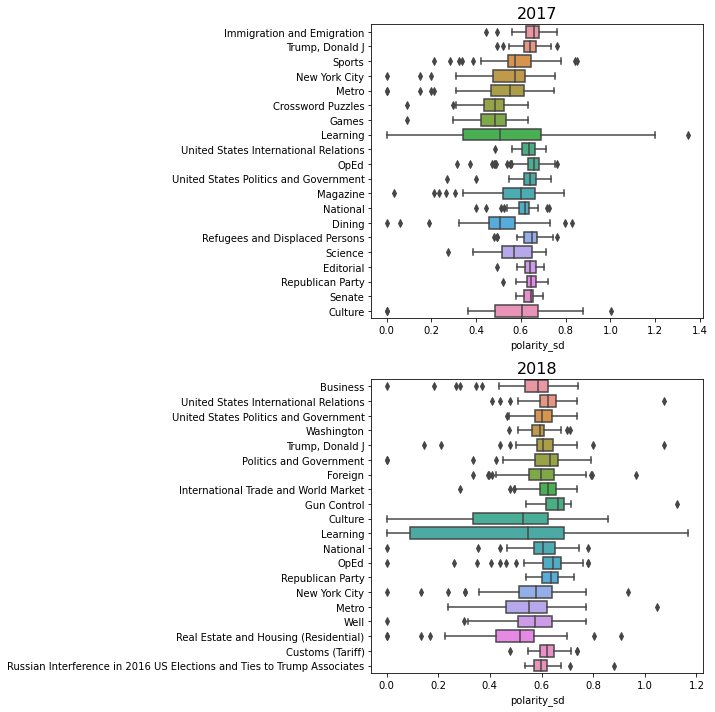

In [20]:
keys2017= keywords2017.sort_values(by='totPol',ascending=False).reset_index(drop = True)
keys2018= keywords2018.sort_values(by='totPol',ascending=False).reset_index(drop = True)

topic2017= [key for key in keys2017.keywords.head(20)]
topic2018= [key for key in keys2018.keywords.head(20)]
art2017= articles2017[articles2017.keywords.isin(topic2017)]
art2018= articles2018[articles2018.keywords.isin(topic2018)]


fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)

plt.subplot(2,1,1)
plt.gca().set_title('2017', fontsize=16)
ax=sns.boxplot(y='keywords',x='polarity_sd', data=art2017)
ax.set(ylabel=None);

plt.subplot(2,1,2)
plt.gca().set_title('2018', fontsize=16)
ax=sns.boxplot(y='keywords',x='polarity_sd', data=art2018)
ax.set(ylabel=None);
plt.tight_layout()
#plt.savefig('boxplot_pol_sd.pdf')

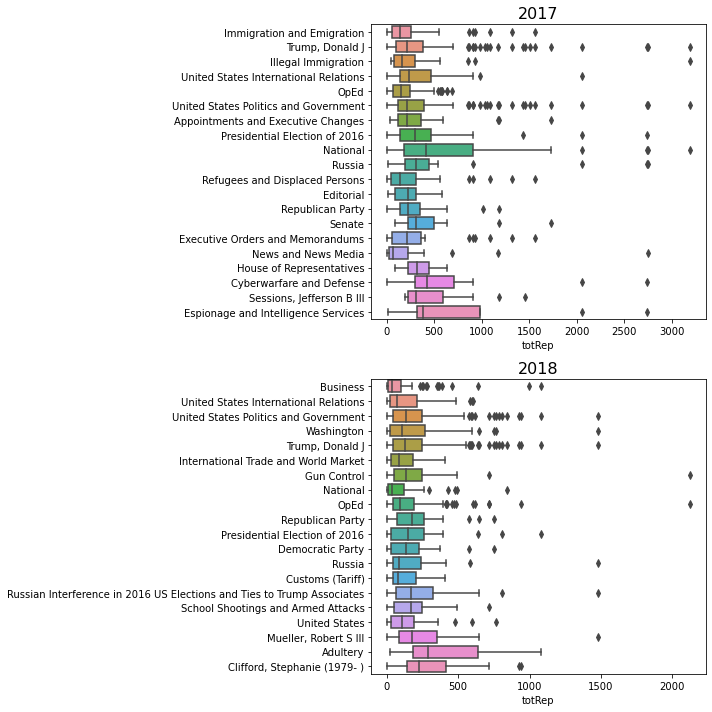

In [19]:
keys2017= keywords2017.sort_values(by='totRep',ascending=False).reset_index(drop = True)
keys2018= keywords2018.sort_values(by='totRep',ascending=False).reset_index(drop = True)

topic2017= [key for key in keys2017.keywords.head(20)]
topic2018= [key for key in keys2018.keywords.head(20)]
art2017= articles2017[articles2017.keywords.isin(topic2017)]
art2018= articles2018[articles2018.keywords.isin(topic2018)]


fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)

plt.subplot(2,1,1)
plt.gca().set_title('2017', fontsize=16)
ax=sns.boxplot(y='keywords',x='totRep', data=art2017)
ax.set(ylabel=None);

plt.subplot(2,1,2)
plt.gca().set_title('2018', fontsize=16)
ax=sns.boxplot(y='keywords',x='totRep', data=art2018)
ax.set(ylabel=None);
plt.tight_layout()
#plt.savefig('boxplot_Rep_sd.pdf')